# Predicting which current NBA players will make the Hall of Fame

<img src="files/data/images/goat.jpg">

Authors: Patanjali Kumar, Vibhor Goel, David Abraham

## Project Abstract

### Introduction
Every year, hundreds of thousands of people around the world watch the basketball games held by the **National Basketball Association** (NBA). The NBA is an American men's professional basketball league composed of 30 teams. Its regular season runs from October to April, with each team playing 82 games, and the league's playoff tournament extends into June. For most players in the NBA, being inducted into the Basketball Hall of Fame in Springfield, Massachusetts would be the crowning achievement of their careers. Thousands have been able to work hard enough and be at an elite enough level to have the opportunity to play in an NBA game, yet only a select handful of them, about 180, have been inducted into the Hall of Fame as a player. Each year’s Hall of Fame class is chosen by a committee and many factors are taken into account to determine whether one should be inducted, however, the criteria can be broken down into “those that have made a significant contribution to the game of basketball.” 
 
### Why its important
Being able to identify those in today’s game whose resumes stack up well enough to match their peers in Springfield is a worthy task. This is the highest and most selective honor in the sport of basketball, and each year’s induction class effectively defines whose careers are deemed integral to telling the story of the sport. Additionally, the world of analytics has taken over many sports, and this is especially true for basketball. In the aftermath of stories like Moneyball, choosing players for a team’s roster is heavily dependent on what the analytics says one should do. This has manifested itself in ways such as the three-point shot going from somewhat of a gimmick that nobody really utilized several decades ago to becoming the most important shot in today’s game, to the point where a player who cannot shoot in today’s game is almost unplayable. Similarly, using these same advanced stats can be very effective in quantifying what is most important for one’s chances of induction into the Basketball Hall of Fame.
 
### How our project works
This tutorial aims to determine what data and which statistics specifically are important in determining a player’s chances of Hall of Fame induction. In our data set, we looked at the stats of players who are already in the Hall of Fame and based off of that we tried to predict who would make the Hall of Fame that is not already in it. Since Hall of Fame eligibility for players requires being retired for at least four full seasons, we looked at players who are still playing currently or who have retired recently. We used data from a very popular website called [Basketball Reference](https://www.basketball-reference.com/), which allows us to look at advanced statistics that go a bit beyond just per-game stats. Though these statistics that can greatly help predict chances of induction, it is important to note that it is impossible to have an all-encompassing prediction model, since off-the-court behavior can affect the voters’ decisions, or as the Board of Trustees puts it, anyone who has “damaged the integrity of the game of basketball.” Taking this into account, our model will attempt to make predictions based solely on a player’s performance on the court, and hopefully be able to help understand what measures of performance are most important in determining players’ chances.  


In [ ]:
!pip install basketball_reference_web_scraper

In [ ]:
!pip install sportsreference

     |████████████████████████████████| 481kB 4.2MB/s 


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy.stats as stats
import requests
from bs4 import BeautifulSoup, SoupStrainer
from sportsreference.nba.roster import Player
from datetime import timedelta, datetime
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, SelectFromModel, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.base import clone
from sklearn.metrics import accuracy_score, brier_score_loss
import sys, os

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

We have gotten both these datasets consisting of basketball players from 1950 (first one from Kaggle, second one from Basketball Referecnce), but are not sure which of the datasets is more exhaustive. To be sure of that, let's check the shape of both datasets to get which one has more players and do a merge accordingly to ensure that we don't miss out on any of the players from either table. We also want the player_ref_id column from the second dataset as that is the primary argument into the basketball reference API to get any information related to a player.

## Data Curation and Cleaning

In [ ]:
players = pd.read_csv("Players.csv")
players2 = pd.read_csv("player_info.csv")
stats = pd.read_csv("Seasons_Stats.csv")

In [ ]:
stats = stats[~stats.Player.isnull()]

In [ ]:
stats.describe()

,Unnamed: 0,Year,Age,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Champion,championships
count,24624.000000,24624.000000,24616.000000,24624.000000,18233.000000,24138.000000,24101.000000,24538.000000,18839.000000,24525.000000,20792.000000,20792.000000,21571.000000,22555.000000,20792.000000,20792.000000,19582.000000,19640.000000,0.0,24585.000000,24585.000000,24585.000000,24101.000000,0.0,20797.000000,20797.000000,20797.000000,20797.000000,24624.000000,24624.000000,24525.000000,18927.000000,18927.000000,15416.000000,24624.000000,24624.000000,24496.000000,24525.000000,24624.000000,24624.000000,23766.000000,20797.000000,20797.000000,24312.000000,24624.000000,20797.000000,20797.000000,19645.000000,24624.000000,24624.000000,24624.000000,24624.000000
mean,12354.094989,1992.594989,26.664405,50.837110,23.593375,1209.720317,12.479071,0.493001,0.158604,0.325455,6.181565,13.708657,9.949210,13.009962,1.648269,1.410624,15.085099,18.906492,NaN,1.257307,1.227395,2.485796,0.065002,NaN,-1.778386,-0.548570,-2.326720,0.559879,195.325820,430.645752,0.430817,22.215037,63.604480,0.248796,178.250447,381.756782,0.445343,0.450658,102.389336,136.775219,0.719279,62.189210,147.199404,224.637381,114.852623,39.897052,24.470260,73.939832,116.339222,510.116350,0.038499,0.228720
std,7125.490095,17.429594,3.841892,26.496161,28.632387,941.146575,6.039014,0.094469,0.187495,0.218971,4.872685,6.636402,5.040283,9.191843,1.017024,1.773348,6.919170,5.448157,NaN,2.136256,1.269613,3.058638,0.102471,NaN,3.792947,2.253106,4.691619,1.336892,188.114361,397.624715,0.095921,38.543366,102.442769,0.176683,179.478923,371.260335,0.099803,0.099200,113.373565,146.078918,0.141824,67.324881,145.921912,228.190203,135.863913,38.713053,36.935084,67.713803,84.791873,492.922981,0.192402,0.707748
min,0.000000,1950.000000,18.000000,1.000000,0.000000,0.000000,-90.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,-5.100000,-1.000000,-2.800000,-2.519000,NaN,-73.800000,-30.400000,-86.700000,-2.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6186.750000,1981.000000,24.000000,27.000000,0.000000,340.000000,9.800000,0.458000,0.005000,0.208000,2.600000,8.800000,5.900000,6.500000,1.100000,0.300000,11.400000,15.400000,NaN,-0.100000,0.200000,0.200000,0.031000,NaN,-3.400000,-1.700000,-4.200000,-0.200000,41.000000,99.000000,0.393000,0.000000,1.000000,0.100000,35.000000,82.000000,0.407000,0.414000,18.000000,27.000000,0.657000,12.000000,33.000000,51.000000,19.000000,9.000000,3.000000,18.000000,39.000000,106.000000,0.000000,0.000000
50%,12357.500000,1996.000000,26.000000,58.000000,8.000000,1053.000000,12.700000,0.506000,0.064000,0.296000,5.400000,12.700000,9.200000,10.500000,1.500000,0.900000,14.200000,18.600000,NaN,0.400000,0.800000,1.400000,0.075000,NaN,-1.500000,-0.500000,-1.800000,0.000000,141.000000,321.000000,0.439000,2.000000,11.000000,0.292000,122.000000,270.000000,0.456000,0.463000,63.000000,88.000000,0.743000,38.000000,106.000000,159.000000,68.000000,29.000000,11.000000,55.000000,109.000000,364.000000,0.000000,0.000000
75%,18524.250000,2007.000000,29.000000,75.000000,45.000000,1971.000000,15.600000,0.544000,0.288000,0.400000,9.000000,18.100000,13.500000,17.600000,2.100000,1.900000,17.700000,22.200000,NaN,1.900000,1.800000,3.800000,0.115000,NaN,0.300000,0.700000,0.300000,0.900000,299.000000,661.000000,0.480000,27.000000,84.000000,0.363000,268.000000,579.250000,0.496000,0.501000,149.000000,201.000000,0.808000,91.000000,212.000000,322.000000,160.000000,60.000000,29.000000,112.000000,182.000000,778.000000,0.000000,0.000000
max,24690.000000,2017.000000,44.000000,88.000000,83.000000,3882.000000,129.100000,1.136000,1.000

In [ ]:
# players.head()
players.describe()

,Unnamed: 0,height,weight,born
count,3922.000000,3921.000000,3921.000000,3921.00000
mean,1960.500000,198.704922,94.783219,1962.37975
std,1132.328206,9.269761,12.039515,20.33491
min,0.000000,160.000000,60.000000,1913.00000
25%,980.250000,190.000000,86.000000,1948.00000
50%,1960.500000,198.000000,95.000000,1964.00000
75%,2940.750000,206.000000,102.000000,1979.00000
max,3921.000000,231.000000,163.000000,1997.00000


In [ ]:
# players2.head()
players2.describe()

,From,To,Wt
count,4803.000000,4803.000000,4798.000000
mean,1986.881532,1991.054757,209.302626
std,21.803348,22.571265,26.170289
min,1947.000000,1947.000000,114.000000
25%,1970.000000,1974.000000,190.000000
50%,1989.000000,1994.000000,210.000000
75%,2006.000000,2012.000000,225.000000
max,2020.000000,2020.000000,360.000000


In [ ]:
combined_df = players2.merge(players, how="left", left_on="player_name", right_on="Player")

In [ ]:
combined_df = combined_df[['player_name','player_ref_id','From','To','height','weight','Birth Date','Pos','Colleges']]

In [ ]:
combined_df.head()

,player_name,player_ref_id,From,To,height,weight,Birth Date,Pos,Colleges
0,Alaa Abdelnaby,abdelal01,1991,1995,208.0,108.0,June 24 1968,F-C,Duke
1,Zaid Abdul-Aziz,abdulza01,1969,1978,206.0,106.0,April 7 1946,C-F,Iowa State
2,Kareem Abdul-Jabbar*,abdulka01,1970,1989,218.0,102.0,April 16 1947,C,UCLA
3,Mahmoud Abdul-Rauf,abdulma02,1991,2001,188.0,83.0,March 9 1969,G,LSU
4,Tariq Abdul-Wahad,abdulta01,1998,2003,198.0,101.0,November 3 1974,F,Michigan San Jose State


We now have the basic player information for all the players matched with their player ids. The Basketball Reference website tells us that from the list of active and inactive players, players with a * at the end of their name are part of the Hall of Fame.

We decided to use Hall of Fame as a base to include all-time greats such as Kareem Abdul Jabbar and Bill Russell into our analysis. We also decided to include players that are active or recently retired. Active players because they shouldn't be left out just because they have not been inducted into the Hall of Fame, and recently retired players because a player can be on the Hall of Fame ballot for many years.

In [ ]:
analysis_data = combined_df[(combined_df.player_name.str.match(".*[*]")) | (combined_df['To']>=2005)]

Let's see how many Hall of Famers we have from this data to get a sense of whether our data has the necessary players and basic player information

In [ ]:
combined_df[(combined_df.player_name.str.match(".*[*]"))].shape

(152, 9)

We see that all the players are in this output are Hall of Famers (denoted by the star in their name according to Basketball Reference) and that all of the basic player information is available the way we need it.

In order to scrape more detailed information from the Basketball Reference website, we require a url to the players' page based on their player_ref_id field. On further observation, we see that the link to a player's page is given in the below format: 

**https://www.basketball-reference.com/players/(insert first letter of last name here)/(insert player_ref_id here).html**

Each player's detailed statistics contains information that provides us with insight into the kind of player they were, which season's they played for. what were the statistics for each of those seasons, how did they perform throughout their career, what were their salaries through each season etc. For the purposes of our analysis, we are going to look at total career statistics and see averages and other trends in overall career statistics to carry out our analysis.

In [ ]:
analysis_data['player_name'].describe()

count           1851
unique          1845
top       Mike James
freq               2
Name: player_name, dtype: object

In [ ]:
analysis_data.head()

,player_name,player_ref_id,From,To,height,weight,Birth Date,Pos,Colleges
2,Kareem Abdul-Jabbar*,abdulka01,1970,1989,218.0,102.0,April 16 1947,C,UCLA
5,Shareef Abdur-Rahim,abdursh01,1997,2008,206.0,102.0,December 11 1976,F,California
9,Álex Abrines,abrinal01,2017,2019,NaN,NaN,August 1 1993,G-F,NaN
10,Alex Acker,ackeral01,2006,2009,196.0,83.0,January 21 1983,G,Pepperdine
14,Quincy Acy,acyqu01,2013,2019,201.0,108.0,October 6 1990,F-C,Baylor


Below, we define a function to gather detailed player statistics by using the [basketball reference api](https://www.basketball-reference.com/) that we've imported above and see player statistics.

In [ ]:
def detailed_player_stats(ref_id):
    player = Player(ref_id)
    points = player.points
    games = player.games_played
    rebounds = player.total_rebounds
    assists = player.assists
    steals = player.steals
    blocks = player.blocks
    mins_played = player.minutes_played
    ppg = points / games if points else None
    rbg = rebounds / games if rebounds else None
    astpg = assists / games if assists else None
    efgp = player.effective_field_goal_percentage
    per = player.player_efficiency_rating
    ws = player.win_shares
    vorp = player.value_over_replacement_player
    tsp = player.true_shooting_percentage
    spg = steals / games if steals else -1
    bpg = blocks / games if blocks else -1
    min_pg = mins_played / games if mins_played else None
        
    player_entry = {'player_ref_id': ref_id,
                    'points_per_game': ppg,
                    'rebounds_per_game': rbg,
                    'assists_per_game': astpg,
                    'effective_fgp': efgp,
                    'efficiency_rating' : per,
                    'win_shares' : ws,
                    'value_over_replacement' : vorp,
                    'true_shooting_pct': tsp,
                    'steals_per_game': spg,
                    'blocks_per_game': bpg,
                    'minutes_per_game': min_pg}

    return player_entry

In [ ]:
players_stats_det = []
for i, idx in enumerate(analysis_data.player_ref_id):
    try:
        players_stats_det.append(detailed_player_stats(idx))
    except:
        print(idx)
players_stats_df = pd.DataFrame(players_stats_det) # convert to dateframe 

Let us use our detailed stats function to get  the detailed statistics of all players using their reference ids (for Basketball Reference) and save it in a dataframe to use later.

We ran this piece of code in Google Colab as it takes a while to create this advanced stats dataframe for all 1850 players. we saved that dataframe from running this piece of code in Google Colab as a csv that we import for further usage from below.

In [ ]:
players_stats_df.to_csv('player_detailed_stats.csv', index=False)

In [ ]:
from google.colab import files
files.download("player_detailed_stats.csv")

Now that we have players' personal details such as height, weight, which college they attended and birth date in one dataframe, and players' advanced statistics like player efficiency rating, true shooting percentage, points per game, etc. in another dataframe, let's merge both dataframes together to create one huge dataframe of all player details.

In [ ]:
players_stats_df = pd.read_csv("player_detailed_stats.csv")

In [ ]:
players_stats_df.head()

,player_ref_id,points_per_game,rebounds_per_game,assists_per_game,effective_fgp,efficiency_rating,win_shares,value_over_replacement,true_shooting_pct,steals_per_game,blocks_per_game,minutes_per_game
0,abdulka01,24.607051,11.179487,3.628205,0.559,24.6,273.4,85.7,0.592,0.743590,2.044231,36.824359
1,abdursh01,18.106024,7.516867,2.540964,0.479,19.0,71.2,21.9,0.549,0.987952,0.768675,34.797590
2,abrinal01,5.310345,1.425287,0.505747,0.525,8.8,5.0,0.1,0.552,0.528736,0.126437,15.959770
3,ackeral01,2.700000,0.966667,0.533333,0.413,8.5,-0.2,-0.2,0.420,0.200000,0.133333,7.800000
4,acyqu01,4.872404,3.498516,0.643917,0.513,11.2,8.7,-0.1,0.553,0.415430,0.400593,16.000000


In [ ]:
players3 = analysis_data.merge(players_stats_df, how='inner', left_on='player_ref_id', right_on='player_ref_id')

In [ ]:
players3.head()

,player_name,player_ref_id,From,To,height,weight,Birth Date,Pos,Colleges,points_per_game,rebounds_per_game,assists_per_game,effective_fgp,efficiency_rating,win_shares,value_over_replacement,true_shooting_pct,steals_per_game,blocks_per_game,minutes_per_game
0,Kareem Abdul-Jabbar*,abdulka01,1970,1989,218.0,102.0,April 16 1947,C,UCLA,24.607051,11.179487,3.628205,0.559,24.6,273.4,85.7,0.592,0.743590,2.044231,36.824359
1,Shareef Abdur-Rahim,abdursh01,1997,2008,206.0,102.0,December 11 1976,F,California,18.106024,7.516867,2.540964,0.479,19.0,71.2,21.9,0.549,0.987952,0.768675,34.797590
2,Álex Abrines,abrinal01,2017,2019,NaN,NaN,August 1 1993,G-F,NaN,5.310345,1.425287,0.505747,0.525,8.8,5.0,0.1,0.552,0.528736,0.126437,15.959770
3,Alex Acker,ackeral01,2006,2009,196.0,83.0,January 21 1983,G,Pepperdine,2.700000,0.966667,0.533333,0.413,8.5,-0.2,-0.2,0.420,0.200000,0.133333,7.800000
4,Quincy Acy,acyqu01,2013,2019,201.0,108.0,October 6 1990,F-C,Baylor,4.872404,3.498516,0.643917,0.513,11.2,8.7,-0.1,0.553,0.415430,0.400593,16.000000


We decided to filter out all players that had data missing for their steals or blocks and that played less than 10 mins per game. An NBA game is 48 mins and any player that is in the discussion for **'Hall of Fame'** has played at least 800-1000 mins during every season in their career.

In [ ]:
players3.drop(players3[players3['steals_per_game'] < 0].index, inplace = True)
players3.drop(players3[players3['blocks_per_game'] < 0].index, inplace = True)
players3.drop(players3[players3['minutes_per_game'] < 10].index, inplace = True)

In [ ]:
players_df = players3[['player_name', 'player_ref_id', 'From','points_per_game', 'rebounds_per_game', 'assists_per_game', 'effective_fgp', 'efficiency_rating', 'win_shares', 'value_over_replacement', 'true_shooting_pct', 'steals_per_game', 'blocks_per_game', 'minutes_per_game']]

In [ ]:
def is_hof(x):
    if '*' in x:
        return 1
    else:
        return 0

In [ ]:
players_df['hof'] = players_df['player_name'].apply(is_hof)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In the following code blocks, we store the MVP winners for each year and get the number of MVPs each player has won. Interestingly, every player who has ever won the MVP award is either already in the Hall of Fame, or will almost certainly make it once they retire. The lone exception is Derrick Rose, who may not end up making it due to his career being shortened from injuries.

In [ ]:
mvp_players = {'Bob Pettit*': [1956, 1959],
              'Bob Cousy*': [1957],
              'Bill Russell*': [1958, 1961, 1962, 1963, 1965],
              'Wilt Chamberlain*': [1960, 1966, 1967, 1968],
              'Oscar Robertson*': [1964],
              'Wes Unseld*': [1969],
              'Willis Reed*': [1970],
              'Kareem Abdul-Jabbar*': [1971, 1972, 1974, 1976, 1977, 1980],
              'Dave Cowens*': [1973],
              'Bob McAdoo*': [1975],
              'Bill Walton*': [1978],
              'Moses Malone*': [1979, 1982, 1983],
              'Julius Erving*': [1981],
              'Larry Bird*': [1984, 1985, 1986],
              'Magic Johnson*': [1987, 1989, 1990],
              'Michael Jordan*': [1988, 1991, 1992, 1996, 1998],
              'Charles Barkley*': [1993],
              'Hakeem Olajuwon*': [1994],
              'David Robinson*': [1995],
              'Karl Malone*': [1997, 1999],
              'Shaquille O\'Neal*': [2000],
              'Allen Iverson*': [2001],
              'Tim Duncan': [2002, 2003],
              'Kevin Garnett': [2004],
              'Steve Nash': [2005, 2006],
              'Dirk Nowitzki': [2007],
              'Kobe Bryant': [2008],
              'LeBron James': [2009, 2010, 2012, 2013],
              'Derrick Rose': [2011],
              'Kevin Durant': [2014],
              'Stephen Curry': [2015, 2016],
              'Russell Westbrook': [2017],
              'James Harden': [2018],
              'Giannis Antetokounmpo': [2019,2020]}

In [ ]:
players_df['MVP'] = 0
for i, row in players_df.iterrows():  
    for j, v in mvp_players.items():
        if row['player_name'] == j:
            players_df.loc[i, 'MVP'] = len(list(v))
            break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


Here, we get the champions for each season, and keep count of how many each team has won.

In [ ]:
# Adding nba champions
teams_champions = {'BOS': [1957, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1968, 1969, 1974, 1976, 1981, 1984, 1986, 2008],
                  'LAL': [1972, 1980, 1982, 1985, 1987, 1988, 2000, 2001, 2002, 2009, 2010, 2020],
                  'MNL': [1949, 1950, 1952, 1953, 1954],
                  'CHI': [1991, 1992, 1993, 1996, 1997, 1998],
                  'GSW': [1975, 2015, 2017, 2018],
                  'PHW': [1947, 1956],
                  'SAS': [1999, 2003, 2005, 2007, 2014],
                  'DET': [1989, 1990, 2004],
                  'MIA': [2006, 2012, 2013],
                  'PHI': [1967, 1983],
                  'SYR': [1955],
                  'HOU': [1994, 1995],
                  'NYK': [1970, 1973],
                  'STL': [1958],
                  'BLB': [1948],
                  'CLE': [2016],
                  'DAL': [2011],
                  'MIL': [1971],
                  'SEA': [1979],
                  'POR': [1977],
                  'ROC': [1951],
                  'WSB': [1978],
                  'TOR': [2019]}

In [ ]:
stats['Champion'] = 0
for i, row in stats.iterrows():  
    for k, v in teams_champions.items():
        for year in v:
            if row['Tm'] != k:
                break
            elif(row['Year'] == year) & (row['Tm'] == k):
                stats.loc[i, 'Champion'] = 1
                break

In [ ]:
players_df['player_name'].count()

1341

In [ ]:
stats['championships'] = stats[['Champion','Player']].groupby('Player').cumsum()

In [ ]:
champions = stats[['Champion', 'Player', 'championships']].groupby(['Player'], sort=False)['championships'].max().reset_index()
champions = champions.sort_values(by='championships', ascending=False)

In [ ]:
players_df = players_df.merge(champions, how='left', left_on='player_name', right_on='Player')

In [ ]:
players_df = players_df.fillna(0)

In [ ]:
all_stars = pd.read_csv('all_star_game_counts.csv', encoding= 'unicode_escape')

In [ ]:
all_stars.head()

,id,Name,Games
0,abdulka01,Kareem Abdul-Jabbar,18
1,jamesle01,LeBron James,16
2,bryanko01,Kobe Bryant,15
3,duncati01,Tim Duncan,15
4,garneke01,Kevin Garnett,14


In [ ]:
players_df = players_df.merge(all_stars, how='left', left_on='player_ref_id', right_on='id').drop(['id', 'Name'], axis=1)

In [ ]:
players_df = players_df.fillna(0)

In [ ]:
players_df = players_df.rename(columns={"Games": 'count_all_stars'})

In [ ]:
def get_box_stat(idx):
  return Player(idx).box_plus_minus

In [ ]:
players_df['box_plus_minus'] = players_df['player_ref_id'].apply(lambda x: get_box_stat(x))

In [ ]:
players_df['points_per_game'].describe()

count    1341.000000
mean        8.959079
std         5.192066
min         1.684211
25%         5.078261
50%         7.470014
75%        11.738636
max        30.123134
Name: points_per_game, dtype: float64

In [ ]:
players_df.head(10)

,player_name,player_ref_id,From,points_per_game,rebounds_per_game,assists_per_game,effective_fgp,efficiency_rating,win_shares,value_over_replacement,true_shooting_pct,steals_per_game,blocks_per_game,minutes_per_game,hof,MVP,championships,count_all_stars,box_plus_minus
0,Kareem Abdul-Jabbar*,abdulka01,1970,24.607051,11.179487,3.628205,0.559,24.6,273.4,85.7,0.592,0.743590,2.044231,36.824359,1,6,6.0,18.0,5.7
1,Shareef Abdur-Rahim,abdursh01,1997,18.106024,7.516867,2.540964,0.479,19.0,71.2,21.9,0.549,0.987952,0.768675,34.797590,0,0,0.0,1.0,1.0
2,Álex Abrines,abrinal01,2017,5.310345,1.425287,0.505747,0.525,8.8,5.0,0.1,0.552,0.528736,0.126437,15.959770,0,0,0.0,0.0,-1.9
3,Quincy Acy,acyqu01,2013,4.872404,3.498516,0.643917,0.513,11.2,8.7,-0.1,0.553,0.415430,0.400593,16.000000,0,0,0.0,0.0,-2.0
4,Jaylen Adams,adamsja01,2019,3.176471,1.764706,1.911765,0.459,7.6,0.1,-0.2,0.474,0.411765,0.147059,12.588235,0,0,0.0,0.0,-4.3
5,Steven Adams,adamsst01,2014,9.794340,7.601887,1.160377,0.589,17.2,45.2,8.6,0.596,0.884906,1.001887,26.805660,0,0,0.0,0.0,0.4
6,Bam Adebayo,adebaba01,2018,10.547085,7.681614,2.928251,0.555,18.4,19.5,5.7,0.599,0.829596,0.892377,25.551570,0,0,0.0,1.0,2.0
7,Deng Adel,adelde01,2019,1.684211,1.000000,0.263158,0.389,2.7,-0.2,-0.3,0.424,0.052632,0.210526,10.210526,0,0,0.0,0.0,-7.5
8,Jeff Adrien,adrieje01,2011,4.633987,4.307190,0.653595,0.474,15.0,4.4,-0.1,0.518,0.326797,0.516340,14.039216,0,0,0.0,0.0,-2.2
9,Arron Afflalo,afflaar01,2008,10.758530,2.855643,1.818898,0.514,11.9,33.5,2.4,0.556,0.447507,0.185039,27.334646,0,0,0.0,0.0,-1.5


In [ ]:
players_df.to_csv('player_df_final.csv', index=False)

## Exploratory Data Analysis

In [ ]:
sns.set_style('darkgrid')

In [ ]:
hof = players_df[players_df['hof']==1]
not_hof = players_df[players_df['hof']==0]

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Points Per Game Distribution for all players')

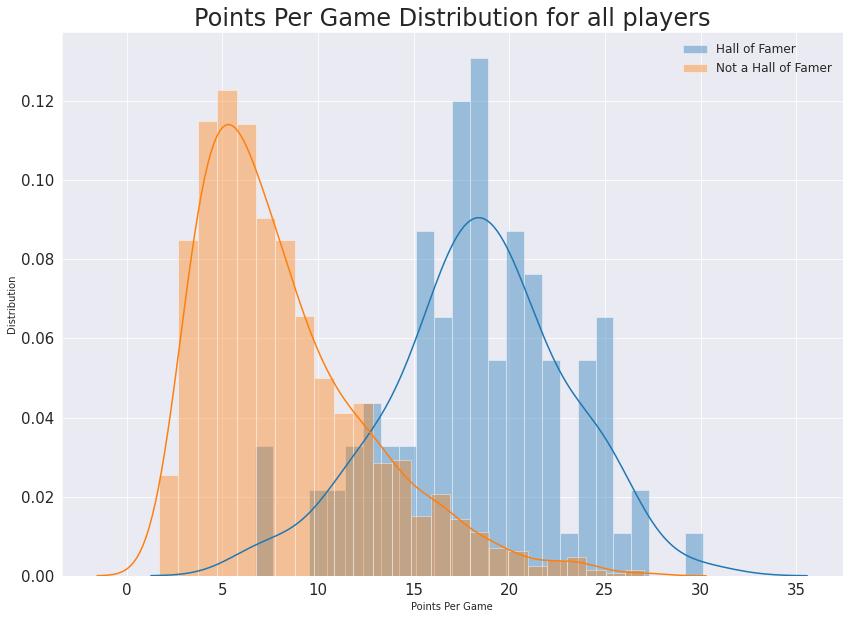

In [ ]:
plt.figure(figsize=(14,10))
sns.distplot(hof['points_per_game'], bins=25, label="Hall of Famer")
sns.distplot(not_hof['points_per_game'], bins=25, label="Not a Hall of Famer")
plt.xlabel("Points Per Game")
plt.ylabel("Distribution")
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(loc=1, frameon=False, prop={'size': 12})
plt.title('Points Per Game Distribution for all players', fontsize=24)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Normal Statistics separated by Hall of Fame Status')

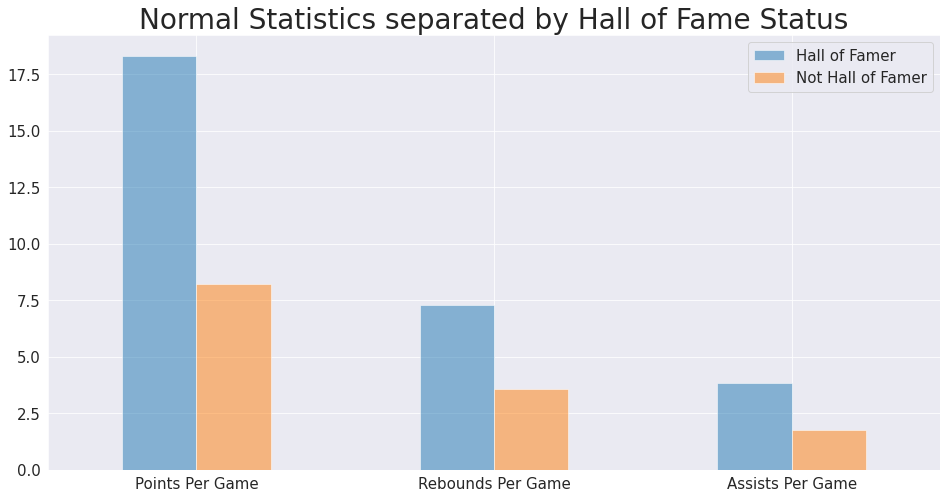

In [ ]:
sort_by_hof = players_df.groupby('hof')['points_per_game', 'rebounds_per_game', 'assists_per_game'] # statistics grouped by hof status
sort_by_hof = sort_by_hof.mean().transpose()  # average stats, transposed for graphing purposes
sort_by_hof = sort_by_hof.rename({1: 'Hall of Famer', 
                                  0: 'Not Hall of Famer'}, 
                                  axis='columns')
sort_by_hof = sort_by_hof.rename({'points_per_game': 'Points Per Game',
                                  'rebounds_per_game': 'Rebounds Per Game',
                                  'assists_per_game': 'Assists Per Game'},
                                   axis='index')
sort_by_hof = sort_by_hof[sort_by_hof.columns[::-1]] # reverse column order
sort_by_hof.plot(kind='bar', figsize=(16,8), alpha=0.5, rot=0)

plt.legend(prop={'size':15}, frameon=True, loc=1)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.title('Normal Statistics separated by Hall of Fame Status', fontsize=28)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Advanced Statistics separated by Hall of Fame Status')

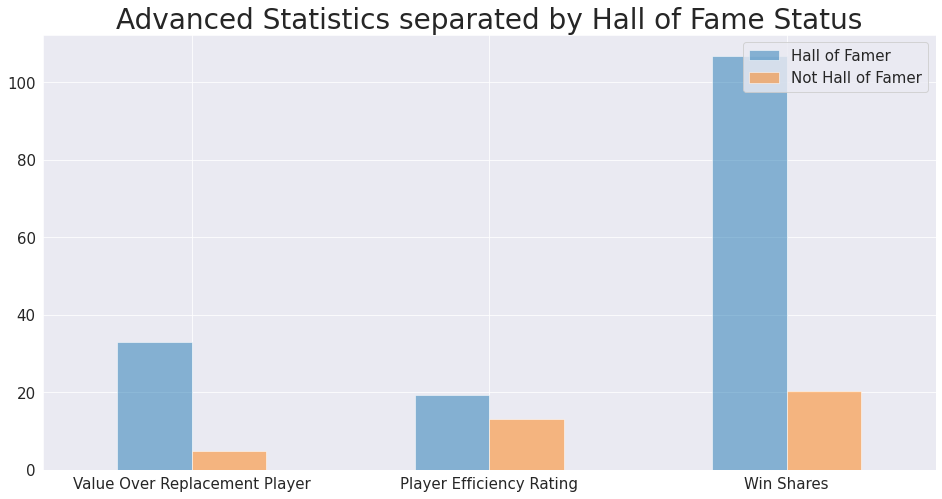

In [ ]:
sort_by_hof = players_df.groupby('hof')['value_over_replacement', 'efficiency_rating', 'win_shares'] # statistics grouped by hof status
sort_by_hof = sort_by_hof.mean().transpose()  # average stats, transposed for graphing purposes
sort_by_hof = sort_by_hof.rename({1: 'Hall of Famer', 
                                  0: 'Not Hall of Famer'}, 
                                  axis='columns')
sort_by_hof = sort_by_hof.rename({'value_over_replacement': 'Value Over Replacement Player',
                                  'efficiency_rating': 'Player Efficiency Rating',
                                  'win_shares': 'Win Shares'},
                                   axis='index')
sort_by_hof = sort_by_hof[sort_by_hof.columns[::-1]] # reverse column order
sort_by_hof.plot(kind='bar', figsize=(16,8), alpha=0.5, rot=0)

plt.legend(prop={'size':15}, frameon=True, loc=1)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.title('Advanced Statistics separated by Hall of Fame Status', fontsize=28)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Number of all star games - distribution for all players')

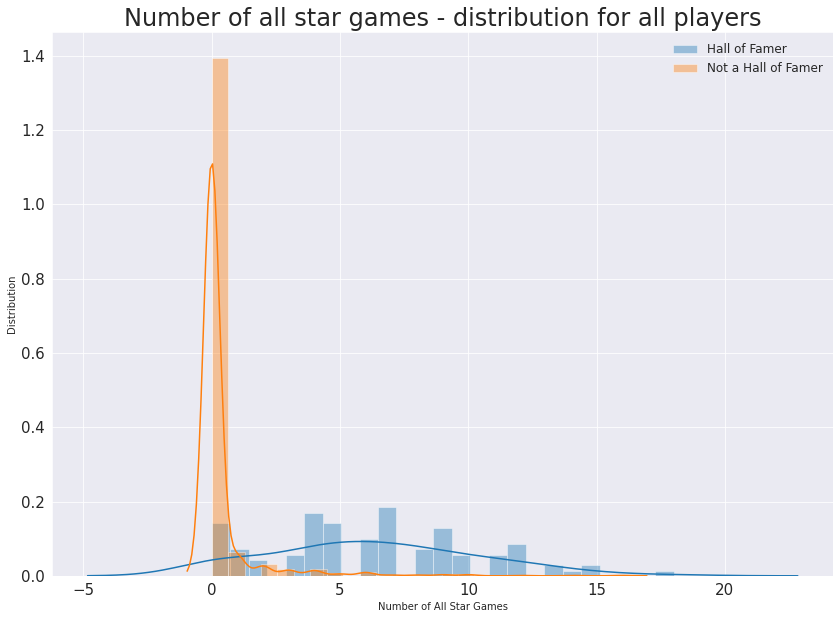

In [ ]:
plt.figure(figsize=(14,10))
sns.distplot(hof['count_all_stars'], bins=25, label="Hall of Famer")
sns.distplot(not_hof['count_all_stars'], bins=25, label="Not a Hall of Famer")
plt.xlabel("Number of All Star Games")
plt.ylabel("Distribution")
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(loc=1, frameon=False, prop={'size': 12})
plt.title('Number of all star games - distribution for all players', fontsize=24)

That's a very interesting result. We are seeing that from our dataframe of all the players, there seems to be a very strong correlation between appearing in multiple All Star games and being inducted into the Hall of Fame. 

Let us try to visualize the correlations between the different features that we have (as stats) in order to move ahead with our analysis. We will plot a heatmap using the seaborn library to 

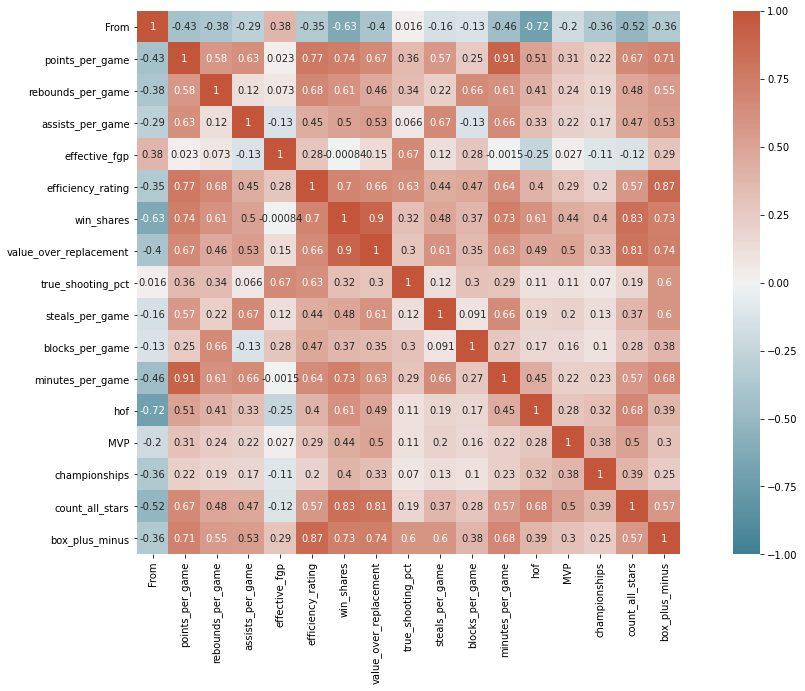

In [ ]:
# visualise correlation matrix
corMatrix = players_df.iloc[:,2:].corr()
fig, ax = plt.subplots(figsize = (19,10))
sns.heatmap(corMatrix, annot=True, ax = ax, vmin = -1, vmax = 1, mask = np.zeros_like(corMatrix, dtype = np.bool),
            cmap = sns.diverging_palette(220, 20, as_cmap = True), square = True)
plt.show()

## Model Building

Let's first write a function that can show us the most important metrics after testing each of our models. We use scikit-learn's brier_score_loss as that type of loss helps us predict probabilities of players to make the Hall of Fame without too many high errors as it specifically eliminates them.

In [ ]:
def show_metrics(model, features):
    accuracy_train = accuracy_score(model.predict(X_train[features]), y_train)
    accuracy_valid = accuracy_score(model.predict(X_val[features]), y_val)
    
    loss_train = brier_score_loss(y_train, model.predict_proba(X_train[features])[:, 1])
    loss_valid = brier_score_loss(y_val, model.predict_proba(X_val[features])[:, 1])
    
    if hasattr(model, "oob_score_"):
        oob_score = model.oob_score_
    else:
        oob_score = ""
    
    print(accuracy_train, accuracy_valid, oob_score, loss_train, loss_valid)

### Hypothesis Test

At the start of the project, during data curation and cleaning, we had picked certain features that we thought would be extremely predictive of whether or not a player makes the Hall of Fame. Let us test whether we made the right choice in picking those features and how important/predictive each of those features are. To do this, let's start with the null hypothesis that all of the features are equally important in determining whether or not a player will make the Hall of Fame. 

In order to test this hypothesis, we are going to try out a Logistic Regression model on our data and use the [scikit-learn's](https://scikit-learn.org/stable/user_guide.html) recursive feature elimination, which recursively removes out features at every step of the training process using the coefficients of the features gained from the previous step. 

In [ ]:
train = players_df[(players_df.To <= 2010) | (players_df.hof == 1)]
test = players_df[(players_df.To > 2010) & (players_df.hof == 0)]

In [ ]:
len(train), len(test)

(334, 659)

In [ ]:
features = ['points_per_game', 'rebounds_per_game', 'assists_per_game', 
            'effective_fgp', 'efficiency_rating', 'win_shares', 
            'value_over_replacement', 'true_shooting_pct', 'steals_per_game', 
            'blocks_per_game', 'minutes_per_game', 'box_plus_minus', 'MVP', 
            'championships', 'count_all_stars']

X_trn = train[features]
y_trn = train["hof"]

X_val = valid[features]
y_val = valid["hof"]

#### Testing functions and other stuff here

In [ ]:
combined_df[combined_df['player_name']=='Draymond Green']

In [ ]:
jordan = Player('jordami01').dataframe

please work


In [ ]:
jordan['box_plus_minus']

In [ ]:
Player('jamesle01').games_played

In [ ]:
lebron['box_plus_minus']

In [ ]:
temp = []
players = ['jordami01', 'jamesle01', 'birdla01', 'rondora01', 'lillada01', 'kuzmaky01', 'irvinky01', 'duranke01', 'leonaka01', 'davisan02','westbru01','curryst01','thompkl01','greendr01']
for player in players:
    try:
        temp.append(detailed_player_stats(player))
    except:
        print(player)
temp_df = pd.DataFrame(temp) # convert to dateframe 

In [ ]:
players3[(players3.player_name.str.match(".*[*]") == False)]

In [ ]:
pd.DataFrame(mvp_players)

In [ ]:
stats